# Classification of cell morphological changes with Neural Networks
_by Alexander Kensert, June 2018_
#### Inspired by
This step by step exercise is highly inspired by the Andrew Ng's **Deep learning** Coursera specialization [Link](https://www.coursera.org/specializations/deep-learning). This step by step exercise will take you through a machine learning workflow which includes reading dataset, create and compile model, train model on dataset, and predict on test set (to evaluate your model). 

#### Datasets
The specific dataset used for this lab will be a subset of the bbbc021v1 dataset [Link](http://mct.aacrjournals.org/content/9/6/1913) (Caie et al., 2010), available from the Broad Bioimage Benchmark Collection [Link](https://www.nature.com/articles/nmeth.2083) (Ljosa et al., 2012).

#### Importance
After you've completed this lab, you will know how to develop and utilize advanced machine learning models (in this case a Neural Network on high content cell images). This approach of classyfing biological cell-images could still be considered very modern --- where traditional approaches of complex workflows, where each step of the analysis require manual implementation, still dominates. However, this approach (utilizing Neural networks) are very promising due to the much better hardware available today, with the capability to perform equal or better than the traditional techniques based on merely the pixel-intensities of the images!

### Load packages

In [1]:
import numpy as np                   # For working with arrays ("a package for scientific computing with Python")
import pandas as pd                  # For reading csv file
import tensorflow as tf              # TensorFlow
import matplotlib.pyplot as plt      # For plotting
from nn_utils import *               # Import helper functions; look inside nn_utils.py for more info.

/Users/alke1432/anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/alke1432/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Read dataset

In [2]:
X_orig, Y_orig = load_dataset()

print("Shape of X_orig = " + str(X_orig.shape))
print("Shape of Y_orig = " + str(Y_orig.shape))

Shape of X_orig = (660, 256, 256, 3)
Shape of Y_orig = (660,)


In [3]:
# Map X to a 0-1 range; and convert Y to one hot encoding (by using the nn_utils function convert_to_one_hot)
X = X_orig/255.
Y = convert_to_one_hot(Y_orig, 6)

print("Shape of X = " + str(X.shape))
print("Shape of Y = " + str(Y.shape))

Shape of X = (660, 256, 256, 3)
Shape of Y = (660, 6)


### Divide dataset into training and test set

In [4]:
np.random.seed(10) # Random seed is used throughout this lab to keep the results consistent.

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:500], indices[500:]
X_train, X_test, Y_train, Y_test = X[train_idx, :, :, :], X[test_idx, :, :, :], Y[train_idx, :], Y[test_idx, :]

print("Shape of X train = " + str(X_train.shape))
print("Shape of Y train = " + str(Y_train.shape))
print("Shape of X test  = " + str(X_test.shape))
print("Shape of Y test  = " + str(Y_test.shape))

Shape of X train = (500, 256, 256, 3)
Shape of Y train = (500, 6)
Shape of X test  = (160, 256, 256, 3)
Shape of Y test  = (160, 6)


### Illustrate input data

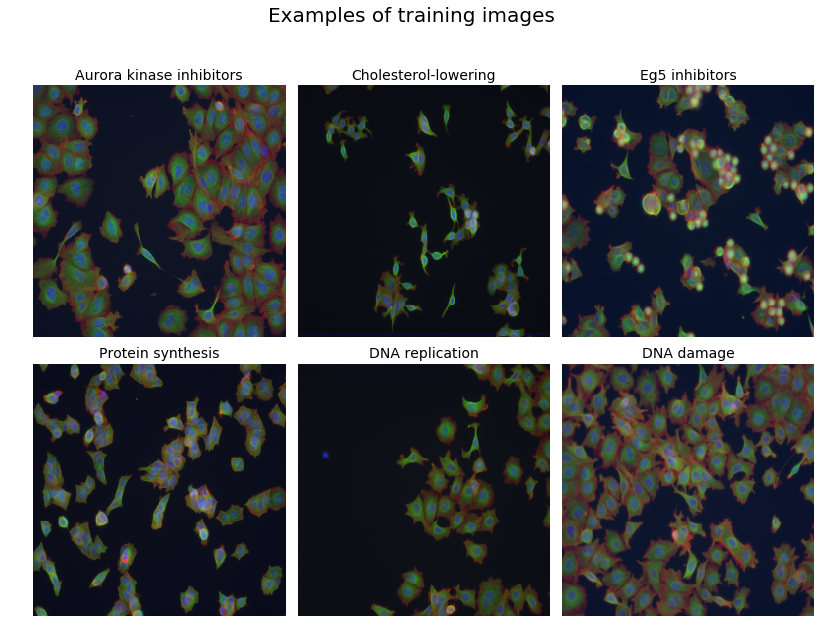

In [5]:
# Run cell to plot few example images of the training set
fig=plt.figure(figsize=(14, 10))
fig.suptitle("Examples of training images", fontsize=20)
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    idx = np.where(np.argmax(Y_train, axis=1) == i-1)[0]
    img = (X_train[idx[2]]*255).astype("uint8")
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.title(Y_orig[train_idx][idx[2]], fontsize=14)
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.imshow(img)

## 1. Convolutional Neural Network with Tensorflow

**In this lab** you will learn how to implement your own convolutional neural network for classifying cell phenotypes. And you will be using the open-source machine learning framework **TensorFlow** to do so (https://www.tensorflow.org). TensorFlow was developed by the **Google Brain** team and is today one of the most widely used machine learning framework in research and industry. 

Convolutional Neural Networks (CNNs) use convolutions instead of the normal fully connected layers, which have proven to be highly successful for image recognition tasks. By convolving **filters** on the input layer and output it to the next layer, the CNN learns to "detect" (or learn) features of the different levels of abstractions throughout the network. With lower-level abstractions (like edges and blobs) in the early layers, and higher-level abstractions (like animal faces) in deeper layers. Figure 1 shows a CNN with 3 convolutional layers, 3 max pooling layers, and two final fully connected layers.

<p>
    <img src="pictures/conv.png" alt="drawing" style="width:1200px;"/>
    <center>Figure 1. A simple illustration of the convolutional neural network that you will implement in section 1.</center>
</p>


**If you're getting stuck** or stumble upon problems, don't hesitate to use Google or similar to search for answers. There are plenty of information out there regarding TensorFlow implementations. It is also very useful to read about the different TensorFlow functions on their website. Also, make use of the lecture notes and try to think carefully about what you're actually implementing.

### 1.1 Create placeholders

Placeholders could be said to be variables that can be fed data later (when we run the session). It allows us to create our operations and build our computation graph without needing the data doing so. 

**Exercise**: Implement a function to create placeholders for input X and output Y [Hint](https://www.tensorflow.org/api_docs/python/tf/placeholder). Input X is the images, and output Y their labels; hence placeholder for input X should have dimension **[None, n_H0, n_W0, n_C0]** and placeholder for output Y dimension **[None, n_y]**. "None" allows for more flexibility, we don't need to specify the number of images that will be fed to the network later on. 

In [6]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    arguments: 
        n_H0 -- height of the image
        n_W0 -- width of the image
        n_C0 -- number of channels of the image
        n_y  -- number of classes
        
    returns:
        X -- placeholder for the data input, of shape (None, n_H0, n_W0, n_C0) and dtype "float"
        Y -- placeholder for the input labels, of shape (None, n_y) and dtype "float"
        
    """
    
    ###--- Start your code here ---### (2 lines of code)
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0), name = 'X')
    Y = tf.placeholder(tf.float32, shape=(None, n_y), name = 'Y')
    ###--- End your code here ---###
    
    return X, Y

In [7]:
# Run this cell to test your function
X, Y = create_placeholders(256, 256, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 256, 256, 3), dtype=float32)
Y = Tensor("Y:0", shape=(?, 6), dtype=float32)


**Expected output:**

<table> 
<tr>
<td>
    X = Tensor("Placeholder:0", shape=(?, 256, 256, 3), dtype=float32)

</td>
</tr>
<tr>
<td>
    Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)

</td>
</tr>
</table>

### 1.2 Initialize parameters

In this section you will initialize the **weights** parameters. The bias parameters are taken care of by TensorFlow. These weights (and biases) are trainable parameters, and will later on be updated with gradient descent methods. 

**Exercise:** Implement initialize_parameters() function with tf.contrib.layers.xavier_initializer(seed = 10). 

**Hint:**
```python 
W = tf.get_variable(name="W", shape=[...], initializer = ...) 
```
Initialize $W1$, $W2$ and $W3$, with shapes of [5,5,3,16], [5,5,16,32], [5,5,32,64] respectively. The first two numbers in each "list" are the shape of the filters (5x5) and the third number is the number of input channels, and the forth number is the chosen number of output channels.

In [8]:
def initialize_parameters():
    
    """
    
    returns a dictionary with the tensors W1, W2, W3.
    """
    
    tf.set_random_seed(10)
    
    ###--- Start your code here ---### (3 lines of code)
    W1 = tf.get_variable(name="W1", shape=[5,5,3,16],  initializer = tf.contrib.layers.xavier_initializer(seed = 10))
    W2 = tf.get_variable(name="W2", shape=[5,5,16,32], initializer = tf.contrib.layers.xavier_initializer(seed = 10))
    W3 = tf.get_variable(name="W3", shape=[5,5,32,64], initializer = tf.contrib.layers.xavier_initializer(seed = 10))
    ###--- Start your code here ---###
    
    
    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3}
    
    return parameters

In [9]:
# Run this cell to test your function
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1][:10]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1][:10]))
    print("W3 = " + str(parameters["W3"].eval()[1,1,1][:10]))

W1 = [-0.02518947  0.08526616  0.01068459 -0.10064837  0.04996547  0.00771768
  0.06277266 -0.08534607 -0.10441076 -0.09985781]
W2 = [-0.01720679  0.00607508  0.02880752  0.00570655  0.03972469  0.02047629
 -0.0242044  -0.0558014  -0.06790373 -0.04631682]
W3 = [-0.01969862 -0.02796849  0.02530041  0.01744844 -0.04213814 -0.03856876
  0.02646131 -0.0229876  -0.02251153 -0.04183786]


**Expected Output:**

<table> 
    <tr>
        <td>
        W1 = 
        </td>
        <td>
[-0.02518947  0.08526616  0.01068459 -0.10064837  0.04996547  0.00771768
  0.06277266 -0.08534607 -0.10441076 -0.09985781]
        </td>
    </tr>
    <tr>
        <td>
        W2 = 
        </td>
        <td>
[-0.01720679  0.00607508  0.02880752  0.00570655  0.03972469  0.02047629
 -0.0242044  -0.0558014  -0.06790373 -0.04631682]
        </td>
    </tr>
    <td>
        W3 = 
        </td>
        <td>
[-0.01969862 -0.02796849  0.02530041  0.01744844 -0.04213814 -0.03856876
  0.02646131 -0.0229876  -0.02251153 -0.04183786]
        </td>
    </tr>
</table>

### 1.3 Forward propagation

In this section you will implement the forward propagation of the network. The forward propagation is needed to feedforward the input data through the network to obtain an output (a training data prediction). This output is then "compared" with the ground truth label (the actual label of the input data) through a Cost function (see next section). The network then propagates backward (a.k.a. back-propagation) based on this Cost function, and updates the weights (from section 1.2) and biases before next iteration. You will later see that Tensorflow allows you to very easily implement the back-propagation with one-line of code (an otherwise complicated implementation).

**Exercise:** Implement the forward_propagation() function to build your model. Model architecture:<br/> 
CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED -> <br/>
-> ReLU -> FULLYCONNECTED <br/>


In detail, you will follow the following steps:
     - Conv2D: stride 2, padding is "SAME"
     - ReLU
     - Max pool: Use an 2 by 2 filter size and an 2 by 2 stride, padding is "SAME"
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
     - Flatten the previous output.
     - FULLYCONNECTED (FC): Use 1024 nodes and kernel_initializer=tf.contrib.layers.xavier_initializer(seed=10)
     - ReLU
     - FULLYCONNECTED (FC) layer: Apply a fully connected layer without a non-linear activation function. 
     The softmax function will be called later together with the cost function (they are lumped together as 
     you will see later). Use 6 nodes and kernel_initializer=tf.contrib.layers.xavier_initializer(seed=10)
     
**Hints:** For conv2d use [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d); for relu use [tf.nn.relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu); for max pooling use [tf.nn.max_pool](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool); for flatten use [tf.contrib.layers.flatten](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten); and finally for FC use [tf.layers.dense](https://www.tensorflow.org/api_docs/python/tf/layers/dense).

In [10]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    -> ReLU -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder: shape (m, height, width, channels)
    parameters -- python dictionary containing your parameters "W1", "W2" and "W3".

    Returns:
    Z5 -- the output of the last linear unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    ###--- START YOUR CODE HERE ---### 
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,2,2,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 4x4, sride 4, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # CONV2D: filters W3, stride 1, padding 'SAME'
    Z3 = tf.nn.conv2d(P2, W3, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A3 = tf.nn.relu(Z3)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P3 = tf.nn.max_pool(A3, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P3 = tf.contrib.layers.flatten(P3)
    
    # Dense layer
    Z4 = tf.layers.dense(P3, 1024, kernel_initializer=tf.contrib.layers.xavier_initializer(seed=10))
    # Relu
    A4 = tf.nn.relu(Z4)
    # FULLY-CONNECTED without non-linear activation function.
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z5 = tf.layers.dense(A4, 6, kernel_initializer=tf.contrib.layers.xavier_initializer(seed=10))
    ###--- END YOUR CODE HERE ---###

    return Z5

In [11]:
# Run this cell to test your function
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(10)
    X, Y = create_placeholders(256, 256, 3, 6)
    parameters = initialize_parameters()
    Z5 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z5, {X: np.random.randn(2,256,256,3), Y: np.random.randn(2,6)})
    print("Z5 = " + str(a))

Z5 = [[ 0.21268588  0.5898833  -0.1474437  -0.12360391 -0.22346927 -0.7871422 ]
 [ 0.21345036  0.5388961  -0.11780731 -0.12841246 -0.16621907 -0.7878238 ]]


**Expected output:**

<table> 
<tr>
<td>
    Z5 = [[ 0.21268588  0.5898833  -0.1474437  -0.12360391 -0.22346927 -0.7871422 ]<br>
 [ 0.21345036  0.5388961  -0.11780731 -0.12841246 -0.16621907 -0.7878238 ]]

</td>
</tr>
</table>

### 1.3.1 GPU implementation

If you have a GPU available, you should later on use the below function. `forward_propagation_gpu()` is exactly the same as `forward_propagation()` but ran on a GPU.

In [12]:
def forward_propagation_gpu(X, parameters, gpu):
    with tf.device('/gpu:'+str(gpu)):
        return forward_propagation(X, parameters)

### 1.4 Compute cost

Implement the compute cost function below. With the cost we want to average the losses over all examples (input) to get an _overall cost_. This could be done in tensorflow by first computing the softmax entropy loss [Link 1](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2) (which computes the softmax activation function as well as the resulting loss), and then compute the mean of the elements [Link 2](https://www.tensorflow.org/api_docs/python/tf/reduce_mean).

**Hints:** Make use of the Link 1 and Link 2 from above: 
- **tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z5, labels = Y)**
- **tf.reduce_mean()**

In [13]:
def compute_cost(Z5, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ###--- START CODE HERE ---### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z5, labels = Y))
    ###--- END CODE HERE ---###
    
    return cost

In [14]:
# Run this cell to test your function
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(10)
    X, Y = create_placeholders(256, 256, 3, 6)
    parameters = initialize_parameters()
    Z4 = forward_propagation(X, parameters)
    cost = compute_cost(Z4, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,256,256,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 2.6181931


**Expected Output:**

<table>
    <td> 
    cost =
    </td> 
    
    <td> 
    2.6181931
    </td> 
</table>

### 1.5 Finalize model

In this last step, you will merge the helper functions that you've implemented above to build your model --- a model trained on high content cell images.

The imported function `random_mini_batches()` will be used to obtain mini-batches. In each for loop a new mini-batch of two lists (minibatch_X and minibatch_Y) will be obtained, which is then fed to the feed_dict.

**Exercise**: Complete the function below. 

The model below should:

- create placeholders
- initialize parameters
- forward propagate
- compute the cost
- optimize

Finally you will create a session, and run the session with `sess.run()` [Link](https://www.tensorflow.org/api_docs/python/tf/Session) (which is inside the for loops num_epochs and minibatches). Thus for each mini-batch you will optimize the function.

**Hints:**<br/> 
For creating the optimizer: `tf.train.AdamOptimizer(learning_rate=...)` and method `minimize(cost)`.<br/>
For running the session: `sess.run([optimizer, cost], feed_dict={X: ..., Y: ...})`

In [15]:
def model(X_train, Y_train, X_test, Y_test, 
          learning_rate = 0.01, num_epochs = 20, minibatch_size = 32):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, shape (None, 256, 256, 3)
    Y_train -- test set, shape (None, n_y = 6)
    X_test -- training set, shape (None, 256, 256, 3)
    Y_test -- test set, shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of the minibatch
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.reset_default_graph()                          
    tf.set_random_seed(10)                            # to keep results consistent (tensorflow seed)
    seed = 10                                         # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    ###--- START YOUR CODE HERE ---###
    
    # I. Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    # II. Initialize parameters
    parameters = initialize_parameters()
    
    # III. Forward propagation: Build the forward propagation in the tensorflow graph
    # Use forward_propagation_gpu(X, parameters, gpu=...) if GPU is available; 
    # Specify which GPU to use by inputting an integer between 0-9 in gpu=... argument.
    Z5 = forward_propagation(X, parameters)
    
    # IV. Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z5, Y)
    
    # V. Backpropagation: Define the tensorflow optimizer. Use a AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    ###--- END YOUR CODE HERE ---###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ###--- START YOUR CODE HERE ---### (1 line of code)
                # VI. Run session
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ###--- END YOUR CODE HERE ---###
                
                minibatch_cost += temp_cost / num_minibatches
            
            # Print the cost every epoch
            if epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch+1, minibatch_cost))
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('Cost')
        plt.xlabel('Number of epochs')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z5, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 1: 1.683048
Cost after epoch 2: 1.240209
Cost after epoch 3: 1.063992
Cost after epoch 4: 1.094325
Cost after epoch 5: 1.013320
Cost after epoch 6: 0.907657
Cost after epoch 7: 0.766954
Cost after epoch 8: 0.690390
Cost after epoch 9: 0.574052
Cost after epoch 10: 0.406674
Cost after epoch 11: 0.465684
Cost after epoch 12: 0.441514
Cost after epoch 13: 0.277889
Cost after epoch 14: 0.207391
Cost after epoch 15: 0.156277
Cost after epoch 16: 0.160355
Cost after epoch 17: 0.213187
Cost after epoch 18: 0.163066
Cost after epoch 19: 0.138676
Cost after epoch 20: 0.119553
Cost after epoch 21: 0.116277
Cost after epoch 22: 0.172484
Cost after epoch 23: 0.182486
Cost after epoch 24: 0.084644
Cost after epoch 25: 0.032436
Cost after epoch 26: 0.016005
Cost after epoch 27: 0.009780
Cost after epoch 28: 0.007679
Cost after epoch 29: 0.009633
Cost after epoch 30: 0.004443


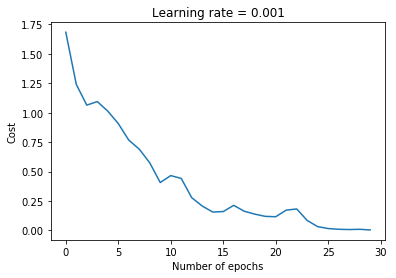

Train Accuracy: 1.0
Test Accuracy: 0.7625


In [16]:
# Run cell to start training and make predictions
_, _, parameters = model(X_train, Y_train, X_test, Y_test,
                         learning_rate  = 0.001, 
                         num_epochs = 30, 
                         minibatch_size = 32)

Training will take some time (~5-10 minutes) if you are running on **CPUs**. Before you go on a break, check that the cost is decreasing after the first few epochs. If you are fortunate and are running on a **GPU**, the training will be signficantly faster (~30-100 times faster).

**Expected output**: your cost and accuracy should match with the below. Importantly, your cost should decrease. Test accuracy can vary quite a lot depending on which learning rate you use and how many epochs you are training; test accuracy is expected to range between 70-80% accuracy.

<table> 
<tr>
    <td> 
    **Cost after epoch 1 =**
    </td>

    <td> 
      1.683048
    </td> 
</tr>
<tr>
    <td> 
    **Cost after epoch 2 =**
    </td>

    <td> 
      1.240209
    </td> 
</tr>
<tr>
    <td> 
    **Train Accuracy   =**
    </td>

    <td> 
      1.0
    </td> 
</tr> 

<tr>
    <td> 
    **Test Accuracy   =**
    </td>

    <td> 
      0.7625
    </td> 
</tr> 
</table>

You obtained a 70%+ accuracy! Good work! Keep in mind that you could possibly improve this network even further by changing the hyperparameter settings and/or add regularization (weight decay or drop out) to the layers.

## 2. Deep residual CNN (~30 layers)
In this section, the final part of this lab, you will implement a deeper state-of-the-art CNN. Specifically, the CNN that you will implement is not too different from the residual CNN presented by He _et al._ (see [article](https://arxiv.org/pdf/1512.03385.pdf)). 

A deep residual network contains dozens of residual blocks (see Figure 2) with intermediate normalization. The identity mapping is often called _skip-connection_ or _shortcut_ and has shown to assist in avoiding the degrading effect of training very deep networks --- a degrading effect that is most apparent for "plain" networks. Thus, the residual implementation made it possible to successfully train a very deep CNN that outperform all the other CNNs that came before.

<p>
    <img src="pictures/residual_block.png" alt="drawing" style="width:400px;"/>
    <center>Figure 2. A residual block - the building block of a residual network.</center>
</p>


In this section we do not need to implement **placeholders** or **cost function** because those can be reused. However, two new fundamental and important implementations will be needed: **batch normalization** and **residual block** (see figure above).

### 2.1 Initialize variable

The get_variable function could be seen as a replacement for the initialize_parameters function. This function returns a variable, like the variables inside initialize_parameters() from section 1.2

In [17]:
# Run this cell to define function get_variable().
def get_variable(name, shape):
    tf.set_random_seed(10)
    return tf.get_variable(name=name, shape=shape, initializer = tf.contrib.layers.xavier_initializer(seed=10))

### 2.2 Batch-normalization

Normalization of input could help in improving Neural Networks. The idea of batch-normalization is to take this normalization to the intermediate layers. Specifically, the batch-normalization normalizes the layer's output before going through the activation function. This should make the Neural Network more stable and faster at training.

We have implemented the batch_norm function for you, but feel free to take a look at it and to read the documentation [Here](https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization). **mean** and **variance** are the mean and variance of the input Tensor, **offset** and **scale** are trainable parameters, and **variance_epsilon** is there to avoid division by 0.

In [18]:
# Run this cell to define function batch_norm().
def batch_norm(input_tensor):
    """
    Batch normalization for a 4-D tensor
    """
    filter_shape = input_tensor.get_shape().as_list()
    mean, var = tf.nn.moments(input_tensor, axes=[0, 1, 2])
    out_channels = filter_shape[3]
    offset = tf.Variable(tf.zeros([out_channels]))
    scale = tf.Variable(tf.ones([out_channels]))
    batch_norm = tf.nn.batch_normalization(input_tensor, mean, var, offset, scale, variance_epsilon=0.00001)
    return batch_norm

### 2.3 Residual block

**Exercise:** Implement the function `residual_block()` below. In detail, you will do the following steps:<br/>
     - Conv2D: stride = [1,stride,stride,1], shape=[3,3,n_C_input,n_C_output], and padding "SAME"
     - Batch-normalization
     - ReLU
     - Conv2D: stride = [1,1,1,1], shape=[3,3,n_C_output,n_C_output], and padding "SAME"
     - Batch-normalization
     - ...
     After you have implemented the above steps we have implemented the final mapping for you.
**Hint** for implementing Conv2D:
```python 
x = tf.nn.conv2d(tensor, 
                 get_variable(name=..., shape=[...]), 
                 strides=[...], 
                 padding=...)
```
    

In [19]:
def residual_block(input_tensor, n_C_input, n_C_output, stride, block):
    """
    Arguments:
        input_tensor -- 4-D tensor
        n_C_input   -- number of channels of input
        n_C_output  -- number of channels of output
        stride      -- size of strides 
        block       -- block number
        
    Returns:
        Tensor -- a residual mapping
        
    """
    ###---START CODE HERE---###
    
    # first convolution layer
    x = tf.nn.conv2d(input_tensor, 
                     get_variable(name="W"+str(block+1)+"a", shape=[3,3,n_C_input,n_C_output]), 
                     strides=[1, stride, stride, 1], 
                     padding="SAME")
    x = batch_norm(x)
    x = tf.nn.relu(x)
    
    # second convolution layer
    x = tf.nn.conv2d(x, 
                     get_variable(name="W"+str(block+1)+"b", shape=[3,3,n_C_output,n_C_output]),
                     strides=[1, 1, 1, 1], 
                     padding="SAME")
    x = batch_norm(x)
    
    ###---END CODE HERE---###
    
    # Input shortcut is added to the stacked layers (shortcut + above; H(x) = x + F(x))
    # Is either identity mapping or 
    # single conv2d layer mapping (to get the same dimensions as the output of the stacked layers)
    if n_C_input != n_C_output:
        conv = tf.nn.conv2d(input_tensor, 
                            get_variable(name="W"+str(block+1)+"_shortcut", shape=[3,3,n_C_input,n_C_output]),
                            strides=[1, stride, stride, 1], 
                            padding="SAME")
        conv = batch_norm(conv)
        mapping = x + conv
    
    else:
        identity = input_tensor
        mapping  = x + identity
    
    mapping = tf.nn.relu(mapping)
    
    return mapping

In [20]:
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(10)
    X, Y      = create_placeholders(256, 256, 3, 6)
    x         = get_variable("x", shape=[3,3,3,16])
    mapping   = residual_block(x, 16, 16, 1, 1)
    init      = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(mapping, {X: np.random.randn(3,256,256,3), Y: np.random.randn(3,6)})
    print("mapping = " + str(a[:,:,:,0][0]))
    

mapping = [[0.        0.4889835 0.       ]
 [0.        1.0255224 0.       ]
 [1.2879109 2.4008121 0.       ]]


**Expected output:**

<table> 
<td>
    mapping = [[0.        0.4889835 0.       ]<br>
              [0.        1.0255224 0.       ]<br>
              [1.2879109 2.4008121 0.       ]]

</td>
</table>

**Note** that we're not using max pooling for this architecture. You will see that we're instead using strides of two to reduce the dimensions.

### 2.4 Resnet forward propagation

**Exercise:** implement function forward_propagation_resnet. Add residual blocks until dimensions of x have been reduced to 4x4x3. Aim for a total of 14 blocks.

**Hint 1:** for implementing the residual network do something like this:
```python 
block1 = residual_block(P1,     n_C_input=32,  n_C_output=64,  stride=2, block=1)
block2 = residual_block(block1, n_C_input=64,  n_C_output=64,  stride=1, block=1)
block3 = residual_block(block2, n_C_input=64,  n_C_output=64,  stride=1, block=3)

block4 = residual_block(block3, n_C_input=64,  n_C_output=128, stride=2, block=4)
block5 = residual_block(block4, n_C_input=128, n_C_output=128, stride=1, block=5)
...
...
...
block14 = residual_block(block13, n_C_input=512, n_C_output=512, stride=1, block=14)
```

**Hint 2:** Input images are of dimensions 256x256x3. So after Z1 = ..., the dimensions have been reduced to 128x128x3 (due to strides = 2), and after P1 = ... reduced further to 64x64x3 (due to strides = 2). This means that everytime **stride = 2** is used, dimensions halves, so make sure you don't reduce the dimensions to less than 4x4x3. Also, stride of 2 doesn't mean that n_C is/has to be increased, we just happen to increase it at that same point as stride of 2 is used.

In [21]:
def forward_propagation_resnet(X):
    W1 = get_variable(name="W1", shape=[5,5,3,32])
    Z1 = tf.nn.conv2d(X, W1, strides = [1,2,2,1], padding = 'SAME')
    Z1 = batch_norm(Z1)
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,3,3,1], strides = [1,2,2,1], padding = 'SAME')
    
    ###---START CODE HERE---###
    block1  = residual_block(P1,      n_C_input=32,  n_C_output=64,  stride=2, block=1)
    block2  = residual_block(block1,  n_C_input=64,  n_C_output=64,  stride=1, block=2)
    block3  = residual_block(block2,  n_C_input=64,  n_C_output=64,  stride=1, block=3)
    
    block4  = residual_block(block3,  n_C_input=64,  n_C_output=128, stride=2, block=4)
    block5  = residual_block(block4,  n_C_input=128, n_C_output=128, stride=1, block=5)
    block6  = residual_block(block5,  n_C_input=128, n_C_output=128, stride=1, block=6)
    block7  = residual_block(block6,  n_C_input=128, n_C_output=128, stride=1, block=7)
    
    block8  = residual_block(block7,  n_C_input=128, n_C_output=256, stride=2, block=8)
    block9  = residual_block(block8,  n_C_input=256, n_C_output=256, stride=1, block=9)
    block10 = residual_block(block9,  n_C_input=256, n_C_output=256, stride=1, block=10)
    block11 = residual_block(block10, n_C_input=256, n_C_output=256, stride=1, block=11)
    
    block12 = residual_block(block11, n_C_input=256, n_C_output=512, stride=2, block=12)
    block13 = residual_block(block12, n_C_input=512, n_C_output=512, stride=1, block=13)
    block14 = residual_block(block13, n_C_input=512, n_C_output=512, stride=1, block=14)
    
    
    ###---END YOUR CODE HERE---###
    
    # Takes the mean of each output channel
    global_pool = tf.reduce_mean(block14, [1,2])
    
    # For this model, only one fully connected layer is used
    final = tf.layers.dense(global_pool, 6, kernel_initializer=tf.contrib.layers.xavier_initializer(seed=10))
    
    return final

In [22]:
# Run this cell to test your function

tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(10)
    X, Y    = create_placeholders(256, 256, 3, 6)
    Z       = forward_propagation_resnet(X)
    init    = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z, {X: np.random.randn(2,256,256,3), Y: np.random.randn(2,6)})
    print("Z = " + str(a))

Z = [[-0.9732146   1.3482124  -0.00801492 -3.1542833  -3.0310855   0.7205707 ]
 [-0.10025907  1.4672053  -0.08543551 -2.4549499  -2.73242    -0.37045878]]


**Expected output:**

<table> 
<td>
    Z = [[-0.9732146   1.3482124  -0.00801492 -3.1542833  -3.0310855   0.7205707 ]<br>
         [-0.10025907  1.4672053  -0.08543551 -2.4549499  -2.73242    -0.37045878]]<br>
</td>
</table>
<br/>

### 2.4.1 GPU implementation

In [23]:
# Run cell to implement function
def forward_propagation_resnet_gpu(X, gpu):
    with tf.device('/gpu:'+str(gpu)):
        return forward_propagation_resnet(X)

### 2.5 Finalize resnet model

**Exercise:** Similar to **Finalize model** from section 1, merge the helper functions that you've implemented:<br/>

- create placeholders
- forward propagatation (important: use `forward_propagation_resnet(X)` and not `forward_propagation(X, parameters)`)
- compute the cost
- create an optimizer

And then finally run the session with `sess.run()`

In [28]:
def resnet(X_train, Y_train, X_test, Y_test, 
          learning_rate = 0.01, num_epochs = 20, minibatch_size = 16):
    """
    Arguments:
    X_train -- training set, shape (None, 256, 256, 3)
    Y_train -- test set, shape (None, n_y = 6)
    X_test -- training set, shape (None, 256, 256, 3)
    Y_test -- test set, shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of the minibatch
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.reset_default_graph()                          
    tf.set_random_seed(10)                            # to keep results consistent (tensorflow seed)
    seed = 10                                         # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    
    ###--- START YOUR CODE HERE ---###
    
    # I. Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    # II. Forward propagation: Build the forward propagation in the tensorflow graph 
    # forward_propagation_resnet_gpu() if GPU is available.
    Z = forward_propagation_resnet(X)
    
    # III. Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # IV. Backpropagation: Define the tensorflow optimizer. Use a MomentumOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    ###--- END YOUR CODE HERE ---###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ###--- START YOUR CODE HERE ---### (1 line of code)
                # V. Run session
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ###--- END YOUR CODE HERE ---###
                
                minibatch_cost += temp_cost / num_minibatches
            
            # Print the cost every epoch
            if epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch+1, minibatch_cost))
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('Cost')
        plt.xlabel('Number of epochs')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 1: 3.061539
Cost after epoch 2: 1.172959
Cost after epoch 3: 1.036176
Cost after epoch 4: 0.893080
Cost after epoch 5: 0.880361
Cost after epoch 6: 0.818282
Cost after epoch 7: 0.733033
Cost after epoch 8: 0.644063
Cost after epoch 9: 0.587494
Cost after epoch 10: 0.489088


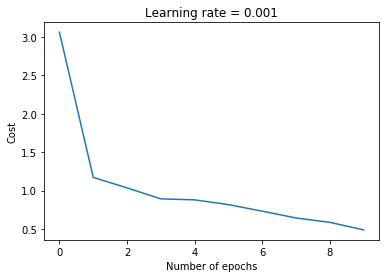

Train Accuracy: 0.884
Test Accuracy: 0.84375


In [29]:
_, _, parameters = resnet(X_train, Y_train, X_test, Y_test, 
                          learning_rate = 0.001, num_epochs = 10, minibatch_size = 32)

**If you are training a deep network like this on CPUs**, it will take quite some time. Hence, we only train for 10 epochs. Normally you would like to train the model for longer to possibly obtain a better model, but for the sake of this lab we limited number of epochs to 10 (which will take ~20 minutes with 4 CPUs).<br/> **If you happen to run on a GPU**, change to 30 epochs and wait approximately 1 minute!

**Expected output**: although it may not match perfectly, your expected output should be similar to ours and your cost value should decrease. Test accuracy can again vary quite a lot, and is expected to range between 85-95%.

<table> 
<tr>
    <td> 
    **Cost after epoch 1 =**
    </td>

    <td> 
      3.061539
    </td> 
</tr>
<tr>
    <td> 
    **Cost after epoch 2 =**
    </td>

    <td> 
      1.172959
    </td> 
</tr>
<tr>
    <td> 
    **10 epochs: Train Accuracy   =**<br/>
    **30 epochs: Train Accuracy   =**
    </td>

    <td> 
      0.884<br/>
      0.98
    </td> 
</tr> 

<tr>
    <td> 
    **10 epochs: Test Accuracy   =**<br/>
    **30 epochs: Test Accuracy   =**
    </td>

    <td> 
      0.84375<br/>
      0.93125
    </td> 
</tr> 
</table>

After implementing a deeper network you attained an even better test set accuracy! Good work! And again, this network could possibly be improved even further by tuning the hyperparameters and/or add regularization. Another important idea with deep learning is that these algorithms usually need a lot of labelled data --- which is lacking for these types of images. To work around this problem, something called data augmentation is usually implemented --- and promising results have been reported on transfer learning where we can use pre-trained parameters from another task to our task, where, as mentioned in section 1, early layers usually learns lower-level abstractions.

### What you have accomplished

1. Define helper functions of a CNN model
2. Put together/create the model
3. Train and optimize the model
4. Make prediction of new unseen data (test set) with the model

The modelling steps done in this lab (above steps) can be succesfully applied to other classification tasks. For example different biological data or recognizing natural images.